In [1]:
# Questions about Crocoddyl Api

In [4]:
import numpy as np
import crocoddyl


In [5]:
# Let's solve a simple problem:

x = np.array([np.random.uniform(-2, 2),1, 1]).T                  # Starting point [X, Y, Theta], Theta should be in the range [-pi, pi]

In [6]:


model = crocoddyl.ActionModelUnicycle()   
model.costWeights = np.array([1.5, 1]).T

problem = crocoddyl.ShootingProblem(x, [model] * 30, model)

ddp  = crocoddyl.SolverDDP(problem)

log = crocoddyl.CallbackLogger()

ddp.setCallbacks([log])
ddp.solve([], [],1000)
print(f"Iterations taken : {ddp.iter}")
print(f"Stopping Criteria : {ddp.stoppingCriteria()}")
print(f"ddp.cost : {ddp.cost}")

Iterations taken : 7
Stopping Criteria : 6.254921675086792e-11
ddp.cost : 27.817805378473075


In [7]:
# Now Value function:

# for the starting_state, x, the corresponding value function is ddp.cost
# Now when subsampling from the state policy trajectory, the value function corresponding to each state in the state policy trajectory is 

running_values = []

for d in ddp.problem.runningDatas:
    running_values.append(d.cost)

# To get the value function corresponding to each state
value_function = []
for i,j in enumerate(running_values):
    value_function.append(sum(running_values[i:]) + ddp.problem.terminalData.cost)

value_function.append(ddp.problem.terminalData.cost)    

In [8]:
# Print state and value pair
for state, value in zip(ddp.xs, value_function):
    print(f"State : {state}, Value : {value}")

State : [1.14783365 1.         1.        ], Value : 27.817805378473075
State : [1.0281299  0.81357246 0.88051896], Value : 20.917596351453774
State : [0.9037495  0.66295485 0.78133469], Value : 15.711864899633797
State : [0.78328078 0.54346122 0.69623485], Value : 11.810093202225302
State : [0.67129801 0.44985792 0.62141914], Value : 8.897313103978279
State : [0.56998053 0.37730917 0.55457403], Value : 6.728400295315023
State : [0.48008812 0.32162834 0.49428627], Value : 5.115978126697019
State : [0.40153616 0.27929617 0.43967543], Value : 3.91821039116652
State : [0.33374285 0.24740728 0.39016595], Value : 3.0283881384678195
State : [0.27584757 0.22359791 0.34534799], Value : 2.3665910738964984
State : [0.2268532  0.20597143 0.30489523], Value : 1.8731904259545566
State : [0.18572075 0.19302671 0.26851866], Value : 1.5038517911138043
State : [0.15143161 0.18359158 0.23594297], Value : 1.2257192077075068
State : [0.1230269  0.17676249 0.20689649], Value : 1.014516290200062
State : [0.0

In [9]:
# Question about stopping criteria. 
# Why is the first term 0 ? What does it correspond to ? 
log.stops

[0.0,
 5.10773582680495,
 0.015206022896256804,
 0.00027656797028999784,
 5.467626877999913e-06,
 1.1986023459808874e-07,
 2.688617804055378e-09,
 6.254921675086792e-11]

In [10]:
# Now what does this correspond to ? Cost-to-go at the start of every iteration ?
log.costs

[29.85721302633832,
 27.82379413367233,
 27.81790991842144,
 27.817807447685563,
 27.817805422992365,
 27.817805379471565,
 27.81780537849552,
 27.817805378473075]

In [11]:
# Use the previous solution to the problem as warmstart guess to the next problem.
warmstart_guess = np.array(ddp.xs)

In [12]:
# Now if I solve another problem with crocoddyl from the same starting position, but with warmstart


model2 = crocoddyl.ActionModelUnicycle()   
model2.costWeights = np.array([1.5, 1]).T

problem2 = crocoddyl.ShootingProblem(x, [model2] * 30, model2)

ddp2  = crocoddyl.SolverDDP(problem2)

log2 = crocoddyl.CallbackLogger()

ddp2.setCallbacks([log2])

ddp2.solve(warmstart_guess, [],1000)

print(f"Iterations taken : {ddp2.iter}")
print(f"Stopping Criteria : {ddp2.stoppingCriteria()}")
print(f"ddp.cost : {ddp2.cost}")

Iterations taken : 7
Stopping Criteria : 1.191417179156875e-10
ddp.cost : 27.81780537847366


In [13]:
log2.costs

[28.141914365374873,
 27.82288032340591,
 27.81791670741371,
 27.817807994815215,
 27.81780544357821,
 27.817805380135695,
 27.817805378515732,
 27.81780537847366]

In [14]:
# Now the first term is not zero
log2.stops

[39.59418387778857,
 0.8723801721309324,
 0.013674057480540198,
 0.0003032742155252268,
 7.2038026087286945e-06,
 1.7843698650834103e-07,
 4.609846649022971e-09,
 1.191417179156875e-10]

In [15]:
# If I wanted the stopping criteria at iter 0 in coldstarted and warmstarted crocoddyl, does that correspond to log.stop[1] and log2.stop[0]

In [16]:
# The second unicycle problem is identical to the first one, but there is not much difference in the number of iterations it took in problem 2. 
# I expected the warmstarted problem to have near 0 stopping criteria in the first iteration, but its 29. Its better than 59 in problem1, 
# but shouldn't that be equal to zero.

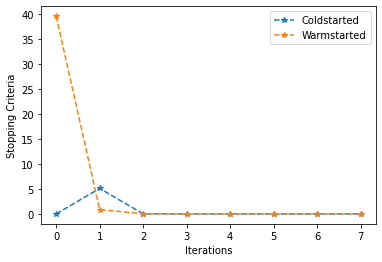

In [17]:
import matplotlib.pyplot as plt

# Is this the correct comparision plot.
plt.plot(log.stops, "--*", label = "Coldstarted")
plt.plot(log2.stops, "--*", label = "Warmstarted")
plt.xlabel("Iterations")
plt.ylabel("Stopping Criteria")
plt.legend()
plt.show()

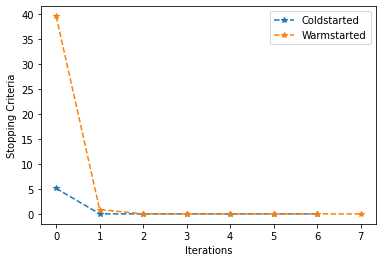

In [18]:
# or should it be this ?

# Is this the correct comparision plot.
plt.plot(log.stops[1:], "--*", label = "Coldstarted") # log.stops[1]
plt.plot(log2.stops, "--*", label = "Warmstarted")
plt.xlabel("Iterations")
plt.ylabel("Stopping Criteria")
plt.legend()
plt.show()


In [34]:
# Last question.
# Ideally the orange line should be a constant line with stopping criteria = 0. So, does it imply that warmstarting with state trajectory alone is not sufficient, 
# Crocddyl also needs a terminal cost model ? 

In [19]:
x

array([1.14783365, 1.        , 1.        ])